In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import spacy 

import sys; sys.path.insert(0, '../') #adds all the code we've written in src
from tqdm.notebook import trange, tqdm
from preprocessing import *

In [3]:
df = pd.read_csv("../../cyberbullying_tweets/cyberbullying_tweets.csv")
tweets = df.tweet_text
tweets = remove_ats(tweets)
tweets = remove_emoji(tweets)
tweets = remove_special(tweets)

df.head()

D:\capstone\src\notebooks\..\preprocessing.py:90: FutureWarning: The default value of regex will change from True to False in a future version.
  return text_arr.str.replace(at_regex, "")
D:\capstone\src\notebooks\..\preprocessing.py:97: FutureWarning: The default value of regex will change from True to False in a future version.
  return text_arr.str.replace(special_chars, "")


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
# !python -m spacy download en_core_web_sm
from spacy_langdetect import LanguageDetector
from spacy.language import Language

@Language.factory('language_detector')
def language_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm", disable = ["tagger", "parser", "attribute_ruler", "ner"])
nlp.add_pipe('sentencizer')
nlp.add_pipe('language_detector', last=True) #2
docs = nlp.pipe(tweets)

In [ ]:
lang = []
score = []

for doc in tqdm(docs, total=len(tweets)):
    lang.append(doc._.language["language"])
    score.append(doc._.language["score"])

  0%|          | 0/47692 [00:00<?, ?it/s]

In [5]:
df["lang"] = lang
df["score"] = score

In [ ]:
df_en = df[df.lang == 'en'].copy().reset_index(drop = True)
df_en

In [7]:
tweets = df_en.tweet_text
tweets = remove_ats(tweets)
tweets = remove_emoji(tweets)
tweets = remove_special(tweets)
tweets = to_lowercase(tweets)
tweets = expand_contractions(tweets)
tweets = remove_stopwords(tweets)
tweets = stem_series(tweets)
tweets = lemmatize_series(tweets)

D:\capstone\src\notebooks\..\preprocessing.py:90: FutureWarning: The default value of regex will change from True to False in a future version.
  return text_arr.str.replace(at_regex, "")
D:\capstone\src\notebooks\..\preprocessing.py:97: FutureWarning: The default value of regex will change from True to False in a future version.
  return text_arr.str.replace(special_chars, "")


In [8]:
cat_dict = {}
for i, type in enumerate(df.cyberbullying_type.unique()):
    cat_dict[type] = i 
    
df_en["y"] = df.cyberbullying_type.map(cat_dict)
df_en["X"] = tweets
df_en

,tweet_text,cyberbullying_type,lang,score,y,X
0,"In other words #katandandre, your food was cra...",not_cyberbullying,en,0.999997,0,word katandandr food crapilici
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,en,0.999995,0,aussietv white theblock imacelebrityau today s...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,en,0.999998,0,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,en,0.999996,0,gio meh p thank head concern anoth angri dude ...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,en,0.999999,0,isi account pretend kurdish account like islam...
...,...,...,...,...,...,...
44607,"Black ppl aren't expected to do anything, depe...",ethnicity,en,0.999997,5,black ppl expect anyth depend anyth yet free p...
44608,Turner did not withhold his disappointment. Tu...,ethnicity,en,0.999996,5,turner withhold disappoint turner call court a...
44609,I swear to God. This dumb nigger bitch. I have...,ethnicity,en,0.999997,5,swear god dumb nigger bitch got bleach hair re...
44610,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,en,0.999996,5,yea fuck nigger fuck unfollow fuck dumb nigger


In [9]:
df_en.groupby('cyberbullying_type').count()

,tweet_text,lang,score,y,X
cyberbullying_type,,,,,
age,7946,7946,7946,7946,7946
ethnicity,7366,7366,7366,7366,7366
gender,7654,7654,7654,7654,7654
not_cyberbullying,6690,6690,6690,6690,6690
other_cyberbullying,6980,6980,6980,6980,6980
religion,7976,7976,7976,7976,7976


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets, df_en.y, test_size=0.2, random_state=42)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))
vectorizer.fit(X_train)
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
print(X_train_bow.shape)
print(X_test_bow.shape)

In [34]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import classification_report 

log_reg = LR(max_iter=10000, solver = 'saga').fit(X_train_bow, y_train)
y_pred = log_reg.predict(X_test_bow)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.52      0.49      0.50      1801
           1       0.64      0.71      0.67      1389
           2       0.73      0.72      0.73      1621
           3       0.40      0.41      0.41      1532
           4       0.57      0.61      0.59      1464
           5       0.75      0.64      0.69      1116

    accuracy                           0.59      8923
   macro avg       0.60      0.60      0.60      8923
weighted avg       0.59      0.59      0.59      8923



In [35]:
from sklearn.feature_extraction.text import TfidfTransformer as tfidf
tf_vectorizer = tfidf()
tf_vectorizer.fit(X_train_bow)

X_train_tfidf = tf_vectorizer.transform(X_train_bow)
X_test_tfidf = tf_vectorizer.transform(X_test_bow)

In [36]:
log_reg_tfidf = LR(max_iter=10000, solver = 'saga').fit(X_train_tfidf, y_train)
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)
print(classification_report(y_pred_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.48      0.52      0.50      1535
           1       0.68      0.73      0.70      1449
           2       0.79      0.73      0.76      1757
           3       0.34      0.43      0.38      1237
           4       0.66      0.62      0.64      1677
           5       0.84      0.63      0.72      1268

    accuracy                           0.62      8923
   macro avg       0.63      0.61      0.62      8923
weighted avg       0.64      0.62      0.62      8923



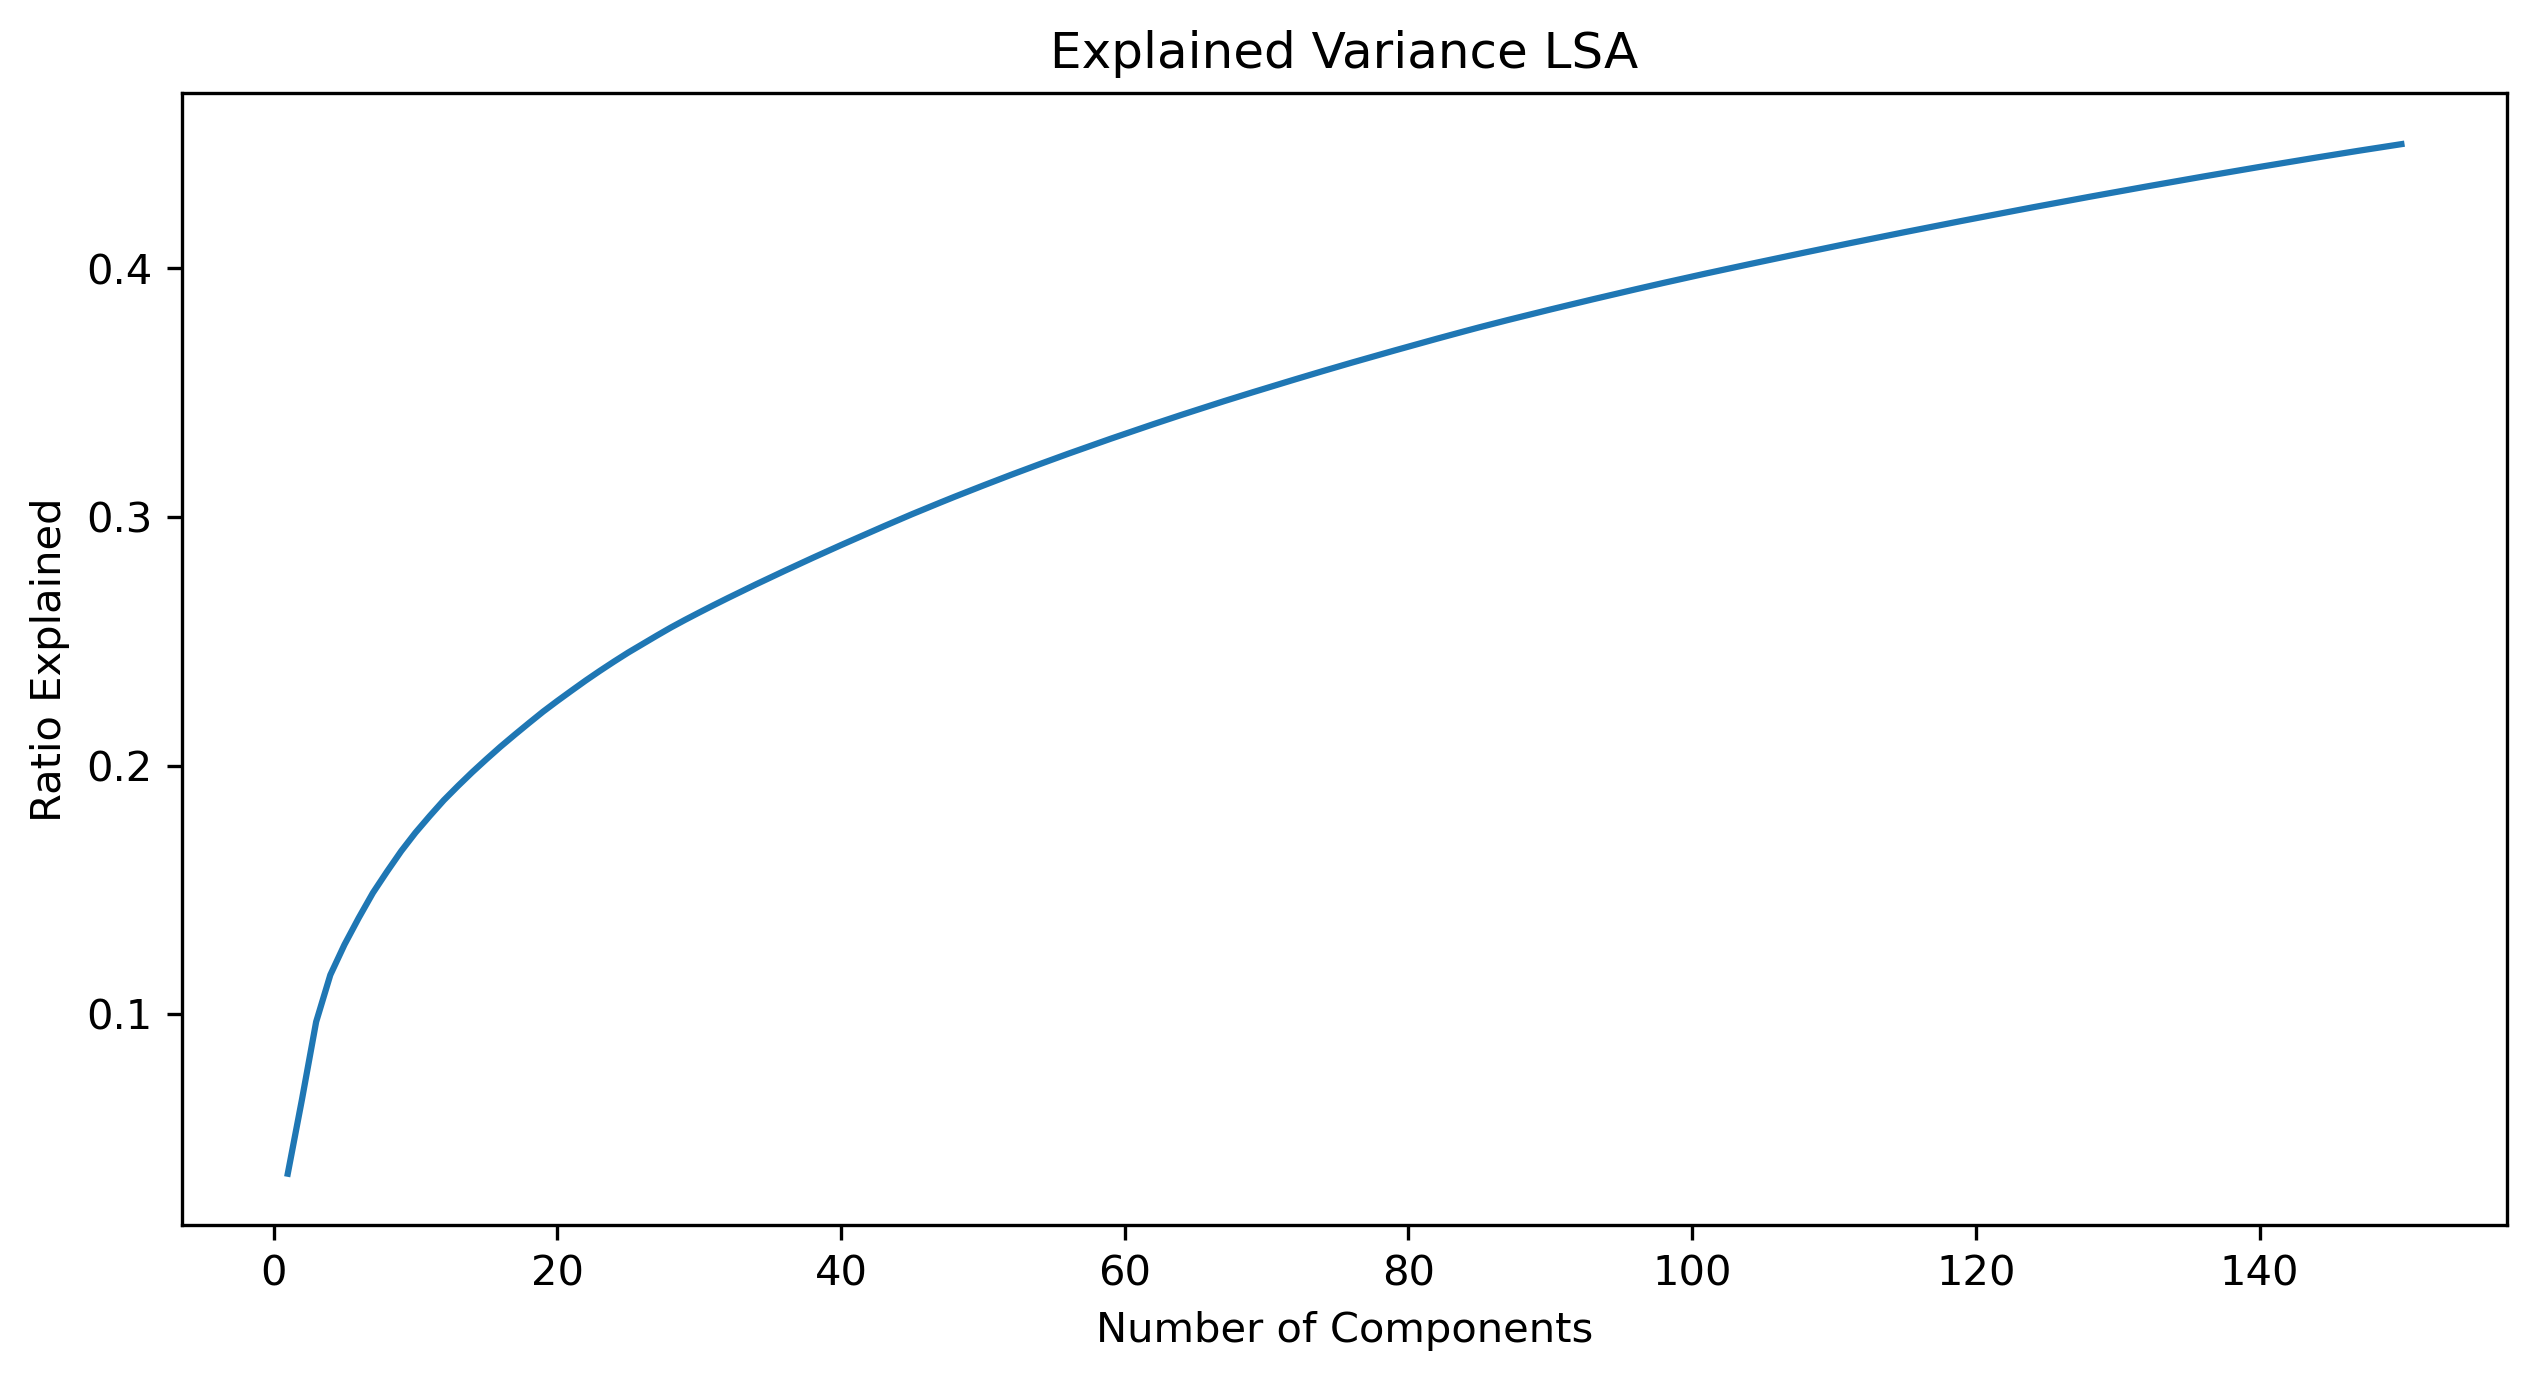

In [18]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 300

x = np.arange(1, 151)
y = reducer.explained_variance_ratio_.cumsum()

plt.plot(x, y)
plt.title("Explained Variance LSA")
plt.ylabel("Ratio Explained")
plt.xlabel("Number of Components")
plt.show()

In [19]:
X_train_lsa = reducer.transform(X_train_bow)
X_test_lsa = reducer.transform(X_test_bow)

log_reg_lsa = LR(max_iter=10000, solver = 'saga').fit(X_train_lsa, y_train)
y_pred_lsa = log_reg_lsa.predict(X_test_lsa)

print(classification_report(y_pred_lsa, y_test))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52      2210
           1       0.59      0.76      0.66      1204
           2       0.73      0.77      0.75      1523
           3       0.33      0.38      0.36      1374
           4       0.55      0.65      0.60      1339
           5       0.86      0.64      0.73      1273

    accuracy                           0.59      8923
   macro avg       0.61      0.61      0.60      8923
weighted avg       0.61      0.59      0.59      8923



In [20]:
import umap
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(X_train_bow)
embedding.embedding_.shape


C:\Users\Ayush\.conda\envs\nlp\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 12224 edges.
It has only fully disconnected 541 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


(35689, 2)

In [31]:
from sklearn.svm import SVC

svc = SVC().fit(X_train_tfidf, y_train)
y_pred = svc.predict(X_test_tfidf)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49      1782
           1       0.66      0.75      0.70      1368
           2       0.77      0.75      0.76      1652
           3       0.34      0.42      0.37      1268
           4       0.63      0.65      0.64      1543
           5       0.89      0.64      0.74      1310

    accuracy                           0.62      8923
   macro avg       0.63      0.61      0.62      8923
weighted avg       0.63      0.62      0.62      8923

